# Import libraries*

In [ ]:
!pip install skfeature-chappers

  Created wheel for skfeature-chappers: filename=skfeature_chappers-1.0.3-py2.py3-none-any.whl size=59510 sha256=9e14a4056e2fb2cb3e76981ae4f2e9074f6cdaa2a5e4347d0db5e17f19b25f2d
  Stored in directory: /root/.cache/pip/wheels/ac/61/bf/1b3a8c232a0072409508c2ec4c12f316e95681ae72ba7315d2
Successfully built skfeature-chappers


In [ ]:
pip install torchxrayvision

     |████████████████████████████████| 42.4MB 76kB/s 
     |████████████████████████████████| 1.9MB 45.1MB/s 


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14633852968105101262, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1087361525341886385
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5348375094615496312
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14524681013128643509
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import csv
import numpy as np
from zipfile import ZipFile
import cv2
import os
from google.colab import files

import matplotlib.pyplot as plt
import math

from skimage.feature import hog
from skimage import exposure

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

import tensorflow

from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras import regularizers

import torch

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import torchxrayvision as xrv

import time

# Functions and data

### Functions*

In [ ]:
def importFile(filename,dataset,preprocess=True):
  # Unzip the files
  zip = ZipFile(filename,'r')
  zip.extractall()

  # Store the information and label of each image as dict
  infoDir = ['_Homework5/train.csv','_Homework5/test.csv']

  info = {}
  datafile = csv.reader(open(infoDir[dataset],'r'))

  for idx, line in enumerate(datafile):
    if idx == 0:
      headers = line
    else:
      info[line[0]] = {headers[i]:line[i] for i in range(1,len(headers))}
      if info[line[0]]['age'] != '':
        info[line[0]]['age'] = int(info[line[0]]['age'])
      if dataset == 0:
        info[line[0]]['covid(label)'] = int(info[line[0]]['covid(label)'])
      

  # Store the images
  imageDir = ['_Homework5/train','_Homework5/test']

  images = []
  label = []
  for file in sorted(os.listdir(imageDir[dataset])):
    # print(file)
    img = cv2.imread(os.path.join(imageDir[dataset],file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img is not None:
      if preprocess == True:
        m = min(img.shape[0], img.shape[1]) #crop to square
        img = cv2.resize(src = img[0:m,0:m], dsize = (224, 224)) #downsize to 224x224
        images.append(img)
      else:
        images.append(img)
      
      if dataset == 0:
        label.append([file, info[file]['covid(label)']])

  return info, images, label

def fisherScore(x,y,prints=True): # x, y should be arrays
  xmean = []

  yVals = np.unique(y) # Unique classes in y
  globalmean = np.mean(x) # Global mean of feature x

  for yval in yVals:
    xmean.append(np.mean(x[np.where(y==yval)]))
  
  intraScatter = 0
  for i in range(yVals.shape[0]):
    intraScatter = intraScatter + np.sum(np.power(x[np.where(y==yVals[i])]-xmean[i],2))
  interScatter = np.sum(np.power(xmean-globalmean,2))

  if prints == True:
    print(xmean)
    print(globalmean)

    print("Intra scatter: {}".format(intraScatter))
    print("Inter scatter: {}".format(interScatter))
    print("======================================")
  
  fScore = intraScatter/interScatter

  return fScore

def splitData(cvX,cvY,fold):
    trainX = []
    trainY = []
    valX = []
    valY = []
    n = math.floor(cvX.shape[0]/5)
    
    valX = cvX[n*fold:n*(fold+1)+1,:] # Validation set contains 50 samples
    valY = cvY[n*fold:n*(fold+1)+1]
    
    trainX = np.concatenate((cvX[0:n*fold,:],cvX[n*(fold+1)+1:,:]),axis=0)
    trainY = np.concatenate((cvY[0:n*fold],cvY[n*(fold+1)+1:]),axis=0)
    
    return trainX,trainY,valX,valY

def filterSelection(x,y,filterName,classifierName):
  accTotal = []
  bestiFeat = 0
  bestAcc = 0
  begin = time.time()
  for ifeat in range(1,math.floor(x.shape[1]),50):
    # Select ifeat best features
    filters = SelectKBest(filterName, k=ifeat)
    hogFilter = filters.fit_transform(x, y)

    np.random.seed(0)
    idx = np.random.permutation(hogFilter.shape[0])
    cvData = hogFilter[idx]
    cvLabel = y[idx]

    acc = []
    for i in range(5):
      trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)

      if classifierName == svm:
        classifier = classifierName.SVC().fit(trainX,trainY)
      else:
        classifier = classifierName().fit(trainX,trainY)
      predict = classifier.predict(valX)

      accuracy = [1 if predict[j]==valY[j] else 0 for j in range(valX.shape[0])]
      acc.append(np.mean(np.array(accuracy)))

      # print("Fold {} accuracy on validation set: {}".format(i+1,np.mean(np.array(accuracy))))
    if np.mean(np.array(acc)) > bestAcc:
      bestiFeat = ifeat
      bestAcc = np.mean(np.array(acc))
      featureSelected = filters.get_support(indices=True) # Get the indices of features selected

    accTotal.append(np.mean(np.array(acc)))
  end = time.time()
  print("Best number of features: {}".format(bestiFeat))
  print("With highest accuracy: {}".format(bestAcc))
  print("Time: {}".format(end-begin))
  print("============================================")

  return accTotal,featureSelected

def wrapperSelection(x,y,filterName,classifierName):
  accTotal = []
  bestiFeat = 0
  bestAcc = 0
  begin = time.time()

  if classifierName == svm:
    classifier = classifierName.SVC()
  else:
    classifier = classifierName()

    np.random.seed(0)
    idx = np.random.permutation(x.shape[0])
    cvData = x[idx]
    cvLabel = y[idx]

  for ifeat in range(1,math.floor(x.shape[1]),5):
    rfe = RFE(estimator=classifier,n_features_to_select=ifeat)

    acc = []
    for i in range(5):
      trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)

      rfe.fit(trainX,trainY)
      # print(model.ranking_)
      predict = rfe.predict(valX)

      accuracy = [1 if predict[j]==valY[j] else 0 for j in range(valX.shape[0])]
      acc.append(np.mean(np.array(accuracy)))

      # print("Fold {} accuracy on validation set: {}".format(i+1,np.mean(np.array(accuracy))))
    if np.mean(np.array(acc)) > bestAcc:
      bestiFeat = ifeat
      bestAcc = np.mean(np.array(acc))
      featureSelected = rfe.get_support(indices=True)

    accTotal.append(np.mean(np.array(acc)))
  end = time.time()
  print("Best number of features: {}".format(bestiFeat))
  print("With highest accuracy: {}".format(bestAcc))
  print("Time: {}".format(end-begin))
  print("============================================")

  return accTotal, featureSelected

def FNN(nlayer, act, dropout, train, trainLabel, epoch, inputSize, verbose):
  layers = [
        Dense(inputSize, activation = act, input_shape=(inputSize,), name="1st_hidden_layer"),Dropout(dropout),#0,1
        Dense(inputSize//2, activation = act, name="2nd_hidden_layer"),Dropout(dropout),#2,3
        Dense(inputSize//4, activation = act, name="3rd_hidden_layer"),Dropout(dropout),#4,5
        Dense(inputSize//8, activation = act, name="4th_hidden_layer"),Dropout(dropout),#6,7
        Dense(inputSize//16, activation = act, name="5th_hidden_layer"),Dropout(dropout),#8,9
        Dense(inputSize//32, activation = act, name="6th_hidden_layer"),Dropout(dropout),#10,11
        Dense(2, activation = 'softmax'),]

  model = Sequential([layers[i] for i in nlayer]+[layers[12]])
  print(model.summary())
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

  begin = time.time()
  values = model.fit(train, to_categorical(trainLabel), epochs=epoch, batch_size = 32, verbose = verbose)
  complete = time.time()

  print("==========================================")
  print("==========================================")
  print("Training accuracy: {}\n Training time: {}".format(values.history['accuracy'][-1],complete-begin))
  print("==========================================")
  print("==========================================")

  return model

def CNN(nlayer, denseLayer, kernelSize, stride, act, dropout, train, trainLabel, epoch,
        verbose, inputSize):
  layers = [
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act, input_shape=inputSize), #0
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #1
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #2,3
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #4
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #5
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #6,7
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #8
            Conv2D(32, kernel_size=kernelSize, strides = stride, activation=act), #9
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #10,11
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #12
            Conv2D(64, kernel_size=kernelSize, strides = stride, activation=act), #13
            MaxPooling2D(pool_size=(2,2)), Dropout(dropout), #14,15
            Flatten(), #16
            ]
  model = Sequential([layers[i] for i in nlayer]+[layers[16]]+denseLayer)
  print(model.summary())
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

  begin = time.time()
  values = model.fit(train,to_categorical(trainLabel),epochs=epoch,batch_size=32,verbose=verbose)
  complete = time.time()

  print("===============================================")
  print("===============================================")
  print("Training accuracy: {}\nTraining time: {}".format(values.history['accuracy'][-1], complete-begin))
  print("===============================================")
  print("===============================================")

  return model

def imagePCA(images,percentage):
  # Get images to apply PCA on
  inputImage = np.array(images)

  # Flatten each image to a 1D vector
  feature = inputImage.reshape(-1,inputImage.shape[1]*inputImage.shape[2])

  # Set PCA to retain 100 * percentage% of original variance
  # Then transform the flattened images to the reduced dimension
  pca = PCA(n_components=percentage)
  featurePCA = pca.fit_transform(feature)
  print(featurePCA.shape)

  # Visualize one image
  i = 11
  plt.figure(figsize=(6*3,7))
  # Plot the PCA reduced image
  plt.subplot(1,3,1)
  plt.imshow(pca.components_[i].reshape(224,224))

  # Inverse transform the reduced image back to original dimension
  featurePCA_inv = pca.inverse_transform(featurePCA).reshape(-1,224,224)
  plt.subplot(1,3,2)
  plt.imshow(featurePCA_inv[i])

  # Plot original image
  plt.subplot(1,3,3)
  plt.imshow(inputImage[i])
  # featurePCA = featurePCA.components_[1].reshape(-1,224,224,1)

  return featurePCA_inv

### Data*

In [ ]:
trainInfo, trainImages, trainLabel = importFile('Homework5 dataset.zip',0)
# testInfo, testImages, testLabel = importFile('Homework5 dataset.zip',1)

# Feature processing

## Feature extraction

#### HOG*

In [ ]:
hogFeatures = []
hogImgs = []
for img in trainImages:
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(10, 10),
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
  hogFeatures.append(fd)
  hogImgs.append(hog_image)
hogFeatures = np.array(hogFeatures)

# hogFeaturesTest = []
# hogImgsTest = []
# for img in testImages:
#   fd, hog_image = hog(img, orientations=8, pixels_per_cell=(30, 30),
#                     cells_per_block=(2, 2), visualize=True, multichannel=False)
#   hogFeaturesTest.append(fd)
#   hogImgsTest.append(hog_image)
# hogFeaturesTest = np.array(hogFeaturesTest)

Visualize HOG features

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

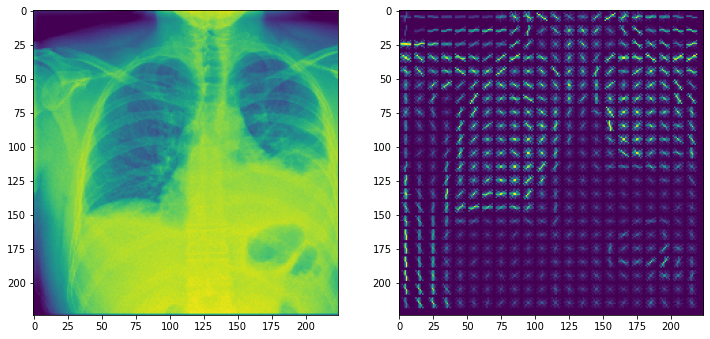

In [10]:
i=116 # Image number
plt.figure(figsize=(6*2,7))
plt.subplot(1,2,1)
plt.imshow(trainImages[i])
plt.subplot(1,2,2)
plt.imshow(exposure.rescale_intensity(hogImgs[i], in_range=(0, 10)))
plt.savefig("HOG feature visualize.png",dpi=120)
files.download("HOG feature visualize.png")

###### Visualize
Feature w.r.t. outcome


*   Histogram
*   Scatter plot



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

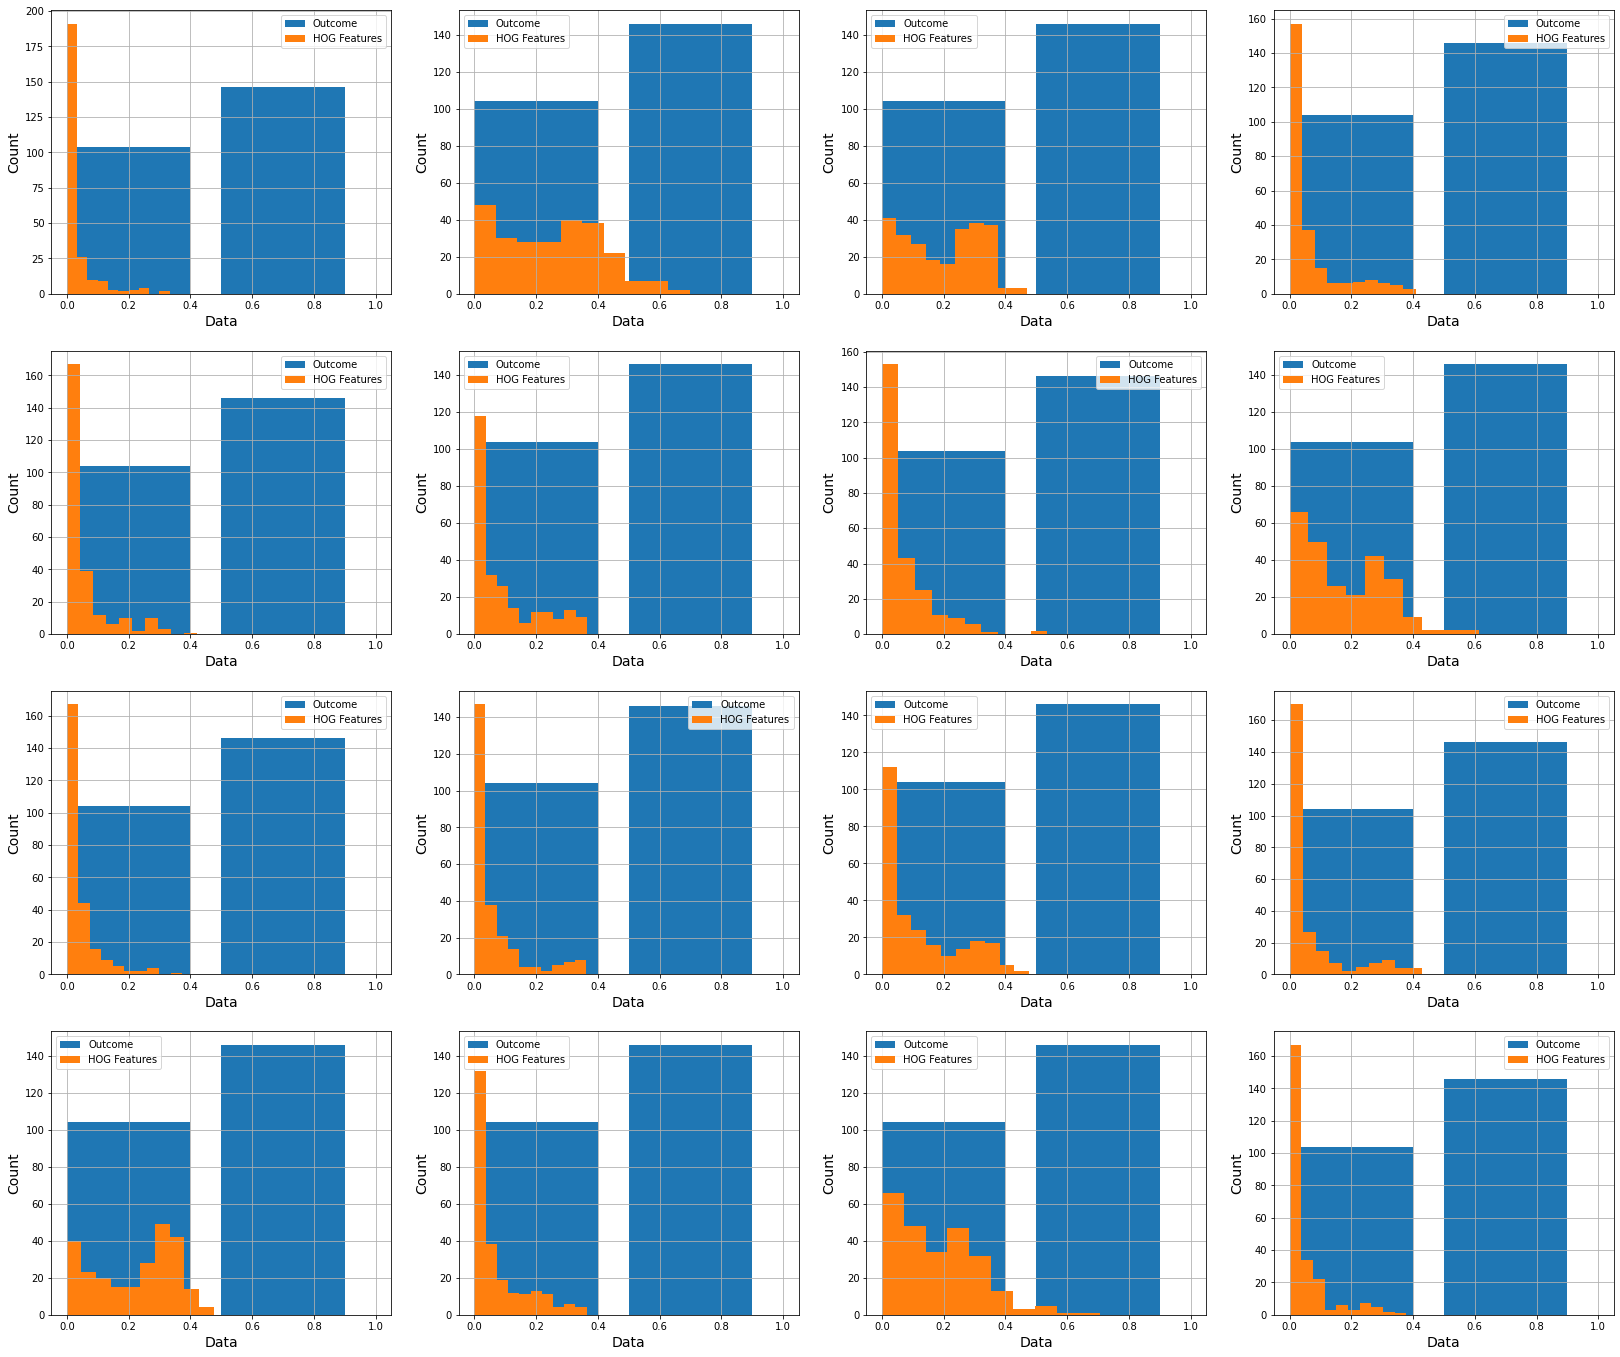

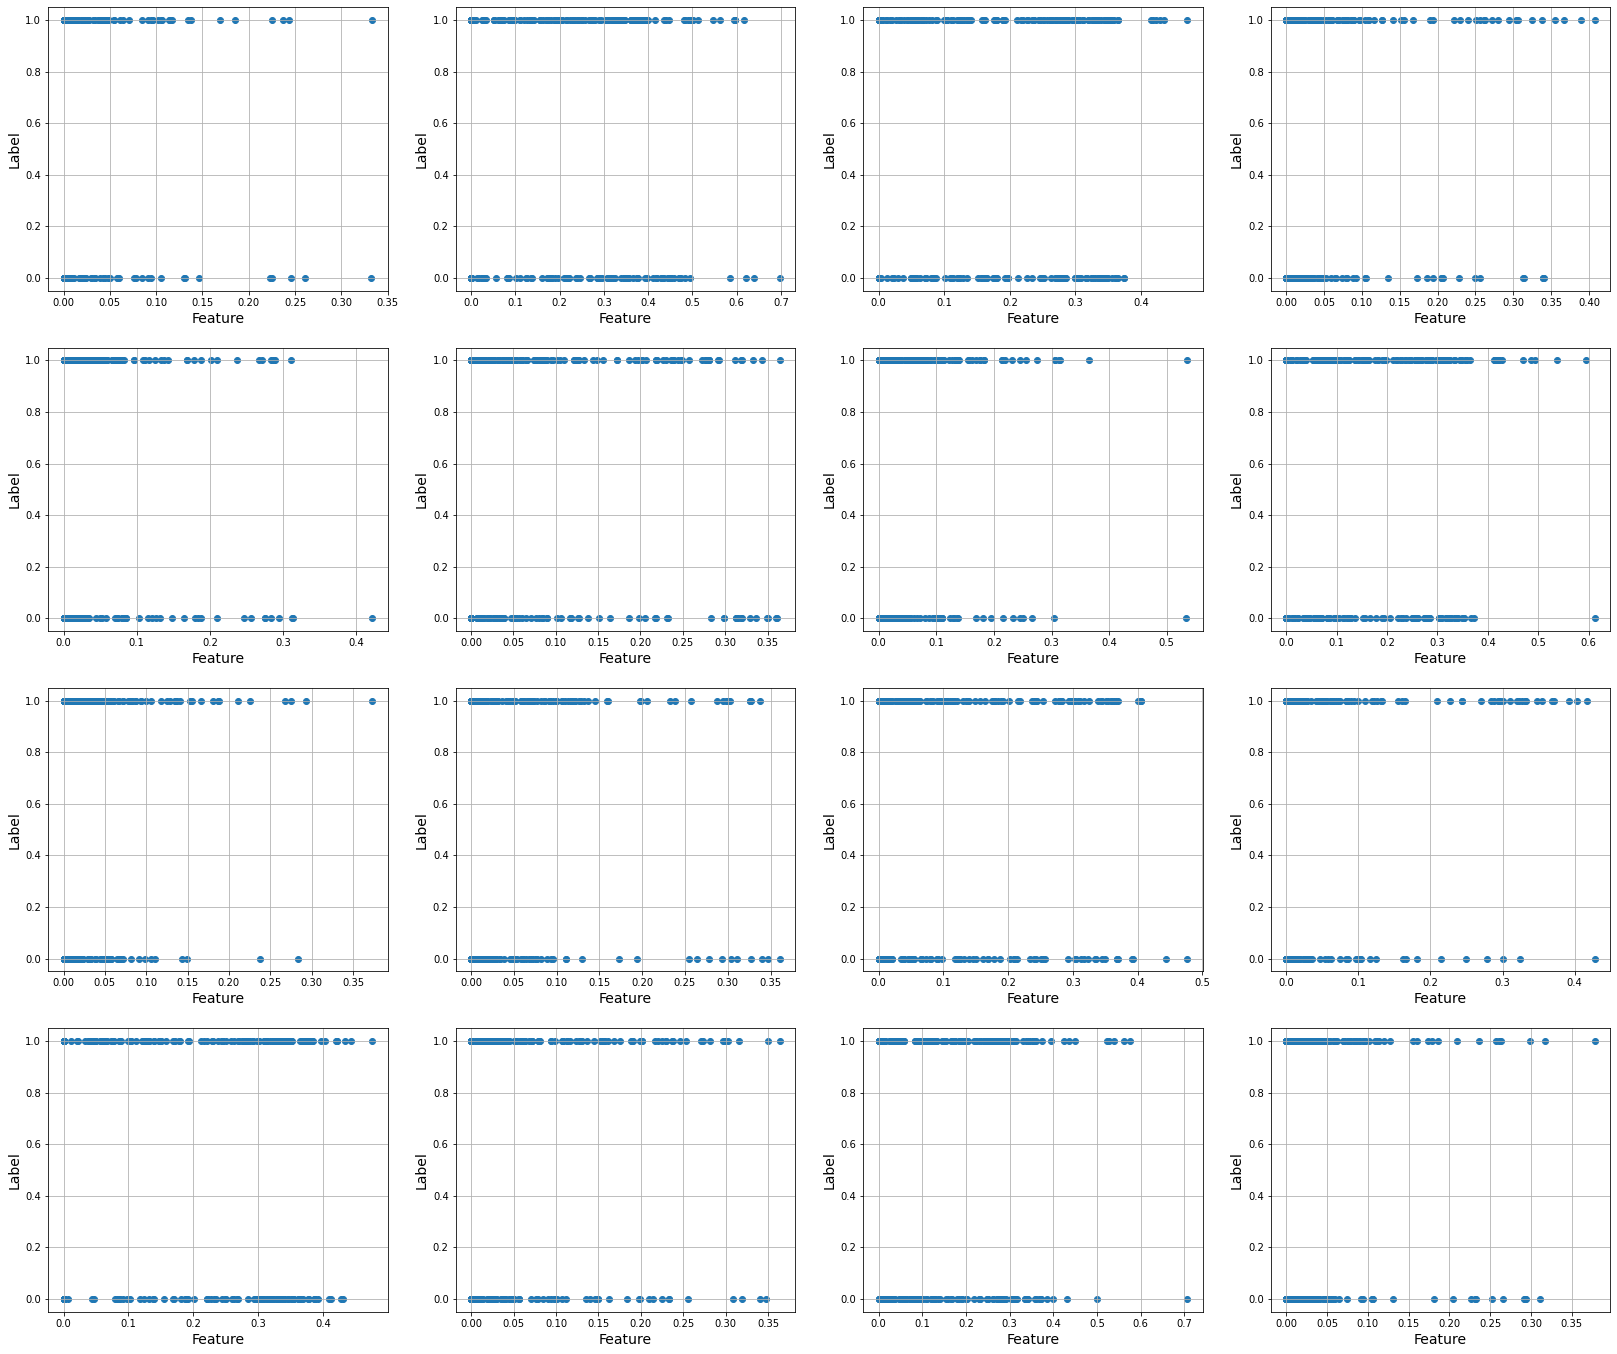

In [ ]:
# Histogram
# Randomly choose 16 features
np.random.seed(100)
idx = np.random.permutation(len(trainImages))
plt.figure(figsize=(7*4,6*4))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.hist([ele[1] for ele in trainLabel],bins=2,label='Outcome',width=0.4)
  plt.hist(hogFeatures[:,idx[i]],bins=10,label='HOG Features')
  plt.xlabel("Data", size=14)
  plt.ylabel("Count", size=14)
  plt.grid(axis='both')
  plt.legend()
plt.savefig("HOG Histogram.png",dpi=120)
files.download("HOG Histogram.png")

# Scatter plots
plt.figure(figsize=(7*4,6*4))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.scatter(hogFeatures[:,idx[i]],[ele[1] for ele in trainLabel])
  plt.xlabel("Feature", size=14)
  plt.ylabel("Label", size=14)
  plt.grid(axis='both')
plt.savefig("HOG Scatter Plot.png",dpi=120)
files.download("HOG Scatter Plot.png")


###### Quantify
Feature w.r.t. outcome


*   Fisher score
*   Conditional information entropy



In [ ]:
# Fisher score
x = []
for i in range(hogFeatures.shape[1]):
  x.append(fisherScore(hogFeatures[:,i],np.array([ele[1] for ele in trainLabel]),prints=False))
print(x)

[18036.622067516975, 165474.86386983754, 33935.375643051775, 90120.31580828624, 1369064.4781435076, 63135.34379756555, 366707.19394883333, 313665.1089666927, 2956735.498255537, 195459.3407277479, 97335.16167703316, 228527.74604985173, 45684.22545737681, 101967.30376192454, 22021.03551574363, 5264407.600740445, 141772.7371856422, 1004772.1732723236, 60314.75605730864, 23466.894153319503, 136569.41993702794, 2777316047.7282224, 75110.69514036618, 20620.158300171435, 6023.0514643998795, 19809.38286974377, 21138.19895142374, 64016.57578113352, 325063.1889019707, 18902.424109077856, 4912.658288412958, 3833.2401823289156, 8055957.456483444, 37656.843506390556, 15475210.877488503, 3262775.0482271826, 33998.8893269515, 156111.19286856463, 57808.4020314959, 251971.30202841433, 36754.43752212664, 14702.504533979229, 159603.23452155545, 8915.907873076465, 62148.50927423248, 90340.70643263518, 90134.27587062868, 311959.288404847, 5834.691197173149, 5297.071352785702, 49681.20021818185, 43529.86733

In [ ]:
import numpy as np
from scipy.sparse import *
from skfeature.utility.construct_W import construct_W

def fisher_score(X, y):
    """
    This function implements the fisher score feature selection, steps are as follows:
    1. Construct the affinity matrix W in fisher score way
    2. For the r-th feature, we define fr = X(:,r), D = diag(W*ones), ones = [1,...,1]', L = D - W
    3. Let fr_hat = fr - (fr'*D*ones)*ones/(ones'*D*ones)
    4. Fisher score for the r-th feature is score = (fr_hat'*D*fr_hat)/(fr_hat'*L*fr_hat)-1
    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data
    y: {numpy array}, shape (n_samples,)
        input class labels
    Output
    ------
    score: {numpy array}, shape (n_features,)
        fisher score for each feature
    Reference
    ---------
    He, Xiaofei et al. "Laplacian Score for Feature Selection." NIPS 2005.
    Duda, Richard et al. "Pattern classification." John Wiley & Sons, 2012.
    """

    # Construct weight matrix W in a fisherScore way
    kwargs = {"neighbor_mode": "supervised", "fisher_score": True, 'y': y}
    W = construct_W(X, **kwargs)

    # build the diagonal D matrix from affinity matrix W
    D = np.array(W.sum(axis=1))
    L = W
    tmp = np.dot(np.transpose(D), X)
    D = diags(np.transpose(D), [0])
    Xt = np.transpose(X)
    t1 = np.transpose(np.dot(Xt, D.todense()))
    t2 = np.transpose(np.dot(Xt, L.todense()))
    # compute the numerator of Lr
    D_prime = np.sum(np.multiply(t1, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # compute the denominator of Lr
    L_prime = np.sum(np.multiply(t2, X), 0) - np.multiply(tmp, tmp)/D.sum()
    # avoid the denominator of Lr to be 0
    D_prime[D_prime < 1e-12] = 10000
    lap_score = 1 - np.array(np.multiply(L_prime, 1/D_prime))[0, :]

    # compute fisher score from laplacian score, where fisher_score = 1/lap_score - 1
    score = 1.0/lap_score - 1
    return np.transpose(score)


def feature_ranking(score):
    """
    Rank features in descending order according to fisher score, the larger the fisher score, the more important the
    feature is
    """
    idx = np.argsort(score, 0)
    return idx[::-1]

fscore1 = fisher_score(hogFeatures,np.array([ele[1] for ele in trainLabel]))
x = np.argmin(fscore1)
print(x)

1239


## Feature selection

#### Filter

Best number of features: 1701
With highest accuracy: 0.8187450980392157
Time: 316.3891086578369


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

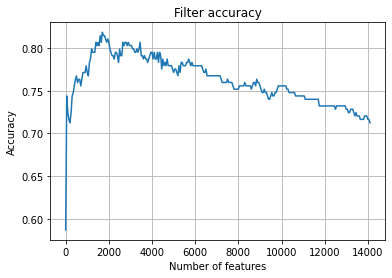

In [ ]:
accTotal, featureFilterIndices = filterSelection(hogFeatures, np.array([ele[1] for ele in trainLabel]),chi2,LogisticRegression)
plt.plot(range(1,math.floor(hogFeatures.shape[1]),50),accTotal)
plt.title("Filter accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.grid(axis='both')
plt.savefig("Filter accuracy.png",dpi=120)
files.download("Filter accuracy.png")

#### Wrapper

Best number of features: 191
With highest accuracy: 0.6773333333333333
Time: 210.75905346870422


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

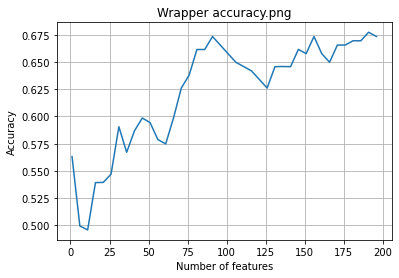

In [ ]:
# PCA on HOG features before using wrapper method
hogFeaturesPCA = PCA(n_components=200).fit_transform(hogFeatures)

accTotal, featureWrapperIndices = wrapperSelection(hogFeaturesPCA, np.array([ele[1] for ele in trainLabel]),chi2,LogisticRegression)
plt.plot(range(1,math.floor(hogFeaturesPCA.shape[1]),5),accTotal)
plt.title("Wrapper accuracy.png")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.grid(axis='both')
plt.savefig("Wrapper accuracy.png",dpi=120)
files.download("Wrapper accuracy.png")

In [ ]:
# PCA on HOG features before using wrapper method
hogFeaturesPCA = PCA(n_components=200).fit_transform(hogFeatures)

classifier = svm.SVC(kernel="linear")
    
rfe = RFE(estimator=classifier,n_features_to_select=10)

np.random.seed(0)
idx = np.random.permutation(hogFeaturesPCA.shape[0])
cvData = hogFeaturesPCA[idx]
cvLabel = np.array([ele[1] for ele in trainLabel])[idx]

trainX,trainY,valX,valY = splitData(cvData,cvLabel,0)
# print(trainX)
model = rfe.fit(trainX,trainY)
print(model.get_support(indices=True))
# print(trainX)

# print(valX)

predict = model.predict(valX)
# print(predict)
# print(valX)

trainX,trainY,valX,valY = splitData(cvData,cvLabel,3)
# print(trainX)
model = rfe.fit(trainX,trainY)
print(model.get_support(indices=True))
# print(trainX)

# print(valX)

predict = model.predict(valX)

[ 11  22  42  45 132 136 140 162 182 193]
[ 41  81 109 132 145 148 158 170 182 193]


In [ ]:
model.predict(valX)

array([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1])

# Adaboost

## Using filter selected features

In [ ]:
# Get features selected from filter methods
feature = hogFeatures[:,featureFilterIndices]

np.random.seed(1)
idx = np.random.permutation(feature.shape[0])
cvData = feature[idx]
cvLabel = np.array([ele[1] for ele in trainLabel])[idx]

accs = []
for i in range(5):
  trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)
  clf = AdaBoostClassifier(base_estimator=LogisticRegression(),n_estimators=100, random_state=0)
  clf.fit(trainX,trainY)
  predict = clf.predict(valX)
  acc = [1 if predict[i]==valY[i] else 0 for i in range(valY.shape[0])]
  print(np.mean(np.array(acc)))
  accs.append(np.mean(np.array(acc)))

print("\n")
print("Accuracy over 5 fold: {}".format(np.mean(np.array(accs))))

0.8823529411764706
0.8235294117647058
0.7254901960784313
0.7254901960784313
0.78


Accuracy over 5 fold: 0.7873725490196077


## Using wrapper selected features

In [ ]:
# Get features selected from wrapper methods
hogFeaturesPCA = PCA(n_components=200).fit_transform(hogFeatures)
feature = hogFeaturesPCA[:,featureWrapperIndices]

np.random.seed(0)
idx = np.random.permutation(feature.shape[0])
cvData = feature[idx]
cvLabel = np.array([ele[1] for ele in trainLabel])[idx]

accs = []
for i in range(5):
  trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)
  clf = AdaBoostClassifier(base_estimator=svm.SVC(),algorithm='SAMME',n_estimators=100, random_state=0)
  clf.fit(trainX,trainY)
  predict = clf.predict(valX)
  acc = [1 if predict[i]==valY[i] else 0 for i in range(valY.shape[0])]
  print(np.mean(np.array(acc)))
  accs.append(np.mean(np.array(acc)))

print("\n")
print("Accuracy over 5 fold: {}".format(np.mean(np.array(accs))))

0.5098039215686274
0.6274509803921569
0.5490196078431373
0.6078431372549019
0.64


Accuracy over 5 fold: 0.5868235294117647


# Neural Network

## FNN with HOG features

In [ ]:
feature = hogFeatures[:,featureFilterIndices]
# feature = PCA(n_components=250).fit_transform(feature)
label = np.array([ele[1] for ele in trainLabel])

np.random.seed(0)
idx = np.random.permutation(feature.shape[0])
cvData = feature[idx]
cvLabel = label[idx]

accs = []
for i in range(5):
  trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)

  modelHOG_FNN = FNN(nlayer=[0,1,2,3,4,5],act='relu',dropout=0.1,train=trainX,
                   trainLabel=trainY,epoch=50,inputSize=feature.shape[1],verbose=0)
  acc = modelHOG_FNN.evaluate(valX,to_categorical(valY))
  accs.append(acc[1])

accs = np.array(accs)
print("=============================================")
print("Accuracy over 5 fold: {}".format(np.mean(accs)))

# predict = modelHOG_FNN.predict(hogFeaturesTest[:,featureIndices])

Model: "sequential_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_hidden_layer (Dense)     (None, 1701)              2895102   
_________________________________________________________________
dropout_922 (Dropout)        (None, 1701)              0         
_________________________________________________________________
2nd_hidden_layer (Dense)     (None, 850)               1446700   
_________________________________________________________________
dropout_923 (Dropout)        (None, 850)               0         
_________________________________________________________________
3rd_hidden_layer (Dense)     (None, 425)               361675    
_________________________________________________________________
dropout_924 (Dropout)        (None, 425)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 2)              

## CNN with original images

(250, 39)
Model: "sequential_196"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1166 (Conv2D)         (None, 111, 111, 32)      320       
_________________________________________________________________
conv2d_1167 (Conv2D)         (None, 55, 55, 32)        9248      
_________________________________________________________________
max_pooling2d_582 (MaxPoolin (None, 27, 27, 32)        0         
_________________________________________________________________
dropout_882 (Dropout)        (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_1168 (Conv2D)         (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_1169 (Conv2D)         (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_583 (MaxPoolin (None, 3, 3, 

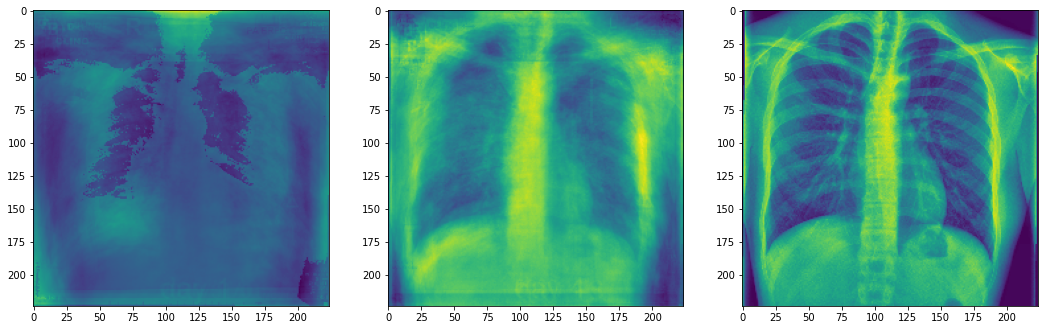

In [ ]:
inputImage = np.array(trainImages)
inputImage = imagePCA(inputImage,0.9)
feature = inputImage.reshape(-1,inputImage.shape[1],inputImage.shape[2],1)
label = np.array([ele[1] for ele in trainLabel])

np.random.seed(0)
idx = np.random.permutation(feature.shape[0])
cvData = feature[idx]
cvLabel = label[idx]

denselayers = [Dense(512,activation='relu'),
               Dense(256,activation='relu'),
               Dense(2,activation='softmax',name='output'),]

accs = []
for i in range(5):
  trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)

  modelHOG_FNN = CNN(nlayer=[0,1,2,3,4,5,6,7],denseLayer=denselayers[1:3],kernelSize=3,stride=2,
                     act='selu',dropout=0.05,train=trainX,trainLabel=trainY,
                     epoch=50,inputSize=(feature.shape[1],feature.shape[2],1),verbose=0)
  acc = modelHOG_FNN.evaluate(valX,to_categorical(valY))
  accs.append(acc[1])

accs = np.array(accs)
print("=============================================")
print("Accuracy over 5 fold: {}".format(np.mean(accs)))

(250, 160)


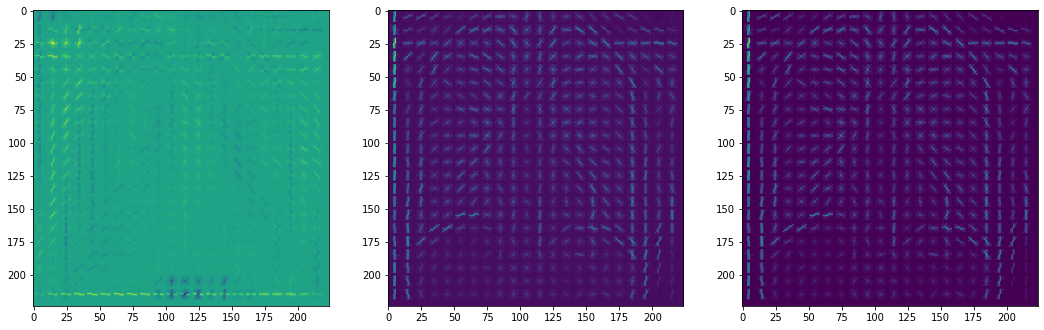

In [ ]:
# Get images to apply PCA on
inputImage = np.array(hogImgs)

# Flatten each image to a 1D vector
feature = inputImage.reshape(-1,inputImage.shape[1]*inputImage.shape[2])

# Set PCA to retain 99% of original variance
pca = PCA(n_components=0.95)
featurePCA = pca.fit_transform(feature)
print(featurePCA.shape)

i = 11
plt.figure(figsize=(6*3,7))
# Plot the PCA reduced image
plt.subplot(1,3,1)
plt.imshow(pca.components_[i].reshape(224,224))

# Inverse transform the reduced image back to original dimension
featurePCA_inv = pca.inverse_transform(featurePCA).reshape(-1,224,224)
plt.subplot(1,3,2)
plt.imshow(featurePCA_inv[i])

# Plot original image
plt.subplot(1,3,3)
plt.imshow(inputImage[i])
# featurePCA = featurePCA.components_[1].reshape(-1,224,224,1)

## CNN with HOG images

(250, 100)
Model: "sequential_263"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1662 (Conv2D)         (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_830 (MaxPoolin (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1160 (Dropout)       (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1664 (Conv2D)         (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_831 (MaxPoolin (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1161 (Dropout)       (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_1666 (Conv2D)         (None, 52, 5

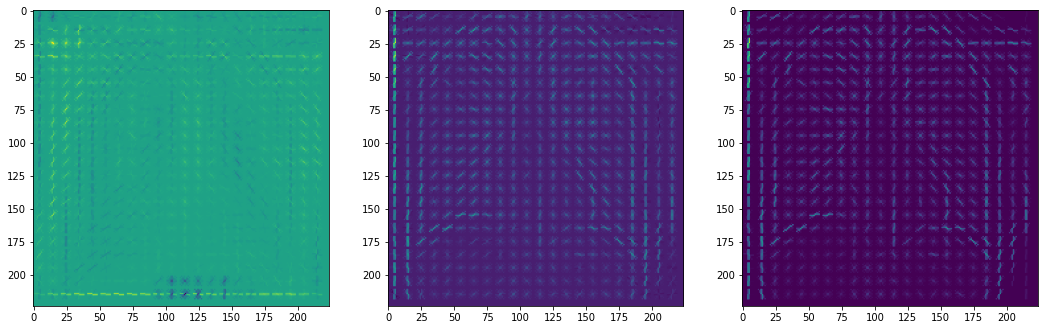

In [ ]:
inputImage = np.array(hogImgs)
inputImage = imagePCA(inputImage,0.86)
feature = inputImage.reshape(-1,inputImage.shape[1],inputImage.shape[2],1)
label = np.array([ele[1] for ele in trainLabel])

np.random.seed(0)
idx = np.random.permutation(feature.shape[0])
cvData = feature[idx]
cvLabel = label[idx]

denselayers = [Dense(512,activation='relu'),
               Dense(256,activation='relu'),
               Dense(2,activation='softmax',name='output'),]

accs = []
for i in range(5):
  trainX,trainY,valX,valY = splitData(cvData,cvLabel,i)

  modelHOG_FNN = CNN(nlayer=[0,2,3,4,6,7,8,10,11,12,14,15],denseLayer=denselayers,kernelSize=3,stride=1,
                     act='relu',dropout=0.05,train=trainX,trainLabel=trainY,
                     epoch=50,inputSize=(feature.shape[1],feature.shape[2],1),verbose=0)
  acc = modelHOG_FNN.evaluate(valX,to_categorical(valY))
  accs.append(acc[1])

accs = np.array(accs)
print("=============================================")
print("Accuracy over 5 fold: {}".format(np.mean(accs)))

## Pre-trained model with torchxrayvision

In [ ]:
model = xrv.models.DenseNet(weights="all")

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]


In [ ]:
hogImgs_tensor = torch.FloatTensor(np.array(hogImgs).reshape(-1,224,224,1))

In [ ]:
model(hogImgs_tensor)

RuntimeError: ignored

# Test data

#### Test dictionary

In [ ]:
x = {}
x.update({'hello':{'h':1,'l':0}})
x.update({'hello1':{'h':1,'l':0}})
print(x)
y = {}
name  = ['hello','hi']
y[name[0]] = {'h':1,'l':0}
y['hi'] = {'h':1,'i':0}
print(y[name[0]]['h'])
titles = ['a','b','c']
keys = ['x','y','z']
values = [1,2,3]
z = {}
z[titles[0]] = {keys[i]:values[i] for i in range(3)}
print(z)

{'hello': {'h': 1, 'l': 0}, 'hello1': {'h': 1, 'l': 0}}
1
{'a': {'x': 1, 'y': 2, 'z': 3}}


#### Test dictionary in dataset

In [ ]:
zip = ZipFile('Homework5 dataset.zip','r')
zip.extractall()

info = {}
datafile = csv.reader(open('_Homework5/train.csv','r'))

for idx, line in enumerate(datafile):
  if idx == 0:
    headers = line
  else:
    info[line[0]] = {headers[i]:line[i] for i in range(1,len(headers))}
    if info[line[0]]['age'] != '':
      info[line[0]]['age'] = int(info[line[0]]['age'])
    info[line[0]]['covid(label)'] = int(info[line[0]]['covid(label)'])


print(info)


{'img_0.jpeg': {'gender': 'F', 'age': 70, 'location': 'Valencia, Spain', 'covid(label)': 1}, 'img_1.jpeg': {'gender': 'F', 'age': 30, 'location': 'University of California Irvine, Orange, California, United States', 'covid(label)': 1}, 'img_10.jpg': {'gender': 'F', 'age': 40, 'location': 'Cairo, Egypt', 'covid(label)': 0}, 'img_100.png': {'gender': 'M', 'age': 44, 'location': 'Wuhan, China', 'covid(label)': 1}, 'img_101.jpg': {'gender': 'F', 'age': '', 'location': 'Hannover Medical School, Hannover, Germany', 'covid(label)': 1}, 'img_102.jpg': {'gender': 'F', 'age': 40, 'location': 'Edinburgh, United Kingdom', 'covid(label)': 0}, 'img_103.png': {'gender': '', 'age': '', 'location': '', 'covid(label)': 1}, 'img_104.jpg': {'gender': 'M', 'age': '', 'location': 'Hannover Medical School, Hannover, Germany', 'covid(label)': 1}, 'img_105.jpg': {'gender': '', 'age': '', 'location': '', 'covid(label)': 1}, 'img_106.jpg': {'gender': 'M', 'age': 26, 'location': '', 'covid(label)': 0}, 'img_107.p

#### Test data saved correctly

In [ ]:
print(trainLabel)

[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]


#### Calculation

In [ ]:
x = np.array([1,1,1,2,2,1,2])
x[np.where(x==1)] = x[np.where(x==1)]-1
x[np.where(x==2)] = x[np.where(x==2)]+1

x = np.power(x,2)
print(np.sum(x))

27


In [ ]:
x = np.array([[1,1,1,2,2,1,2,1],[1,1,1,1,2,2,2,0]])
y = np.array([0,0,1,1,0,1,0,1])

print(fisherScore(x[0],y))
print(fisherScore(x[1],y))

[1.5, 1.25]
1.375
Intra scatter: 1.75
Inter scatter: 0.03125
56.0
[1.5, 1.0]
1.25
Intra scatter: 3.0
Inter scatter: 0.125
24.0


In [ ]:
x = np.array([[1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]])
y = np.array([1,0,1,0,1])
z = np.where(y==1)
print(x[:,z].reshape(x.shape[0],-1))
print(z)

[[ 1  3  5]
 [ 6  8 10]
 [11 13 15]]
(array([0, 2, 4]),)


In [ ]:
from sklearn.decomposition import PCA
x = np.array([[1,-1],[0,1],[-1,0]])
pca = PCA(n_components=1)
pca.fit(x)
sigma = pca.get_covariance()
print(pca.get_covariance())

[[ 1.  -0.5]
 [-0.5  1. ]]


In [ ]:
from numpy import linalg as LA
sigma1 = np.array([[2/3,-1/3],[-1/3,2/3]])
w,v = LA.eig(sigma1)
w,v

(array([1.        , 0.33333333]), array([[ 0.70710678,  0.70710678],
        [-0.70710678,  0.70710678]]))

In [ ]:
def cndtEntropy(feature,label,printNum):
  featureValue = np.unique(feature)
  infoEntropyFeature = []

  for i in featureValue:
    index = np.where(feature==i)[0]

    labelI = label[index]

    malignantNum = len(np.where(labelI==0)[0])
    benignNum = len(np.where(labelI==1)[0])
    totalNum = malignantNum + benignNum
    if totalNum != len(index):
      print("Wrong calculation!")

    if printNum == True:
      print("Malignant number: {}".format(malignantNum))
      print("Benign number: {}".format(benignNum))
      print("=========================")
      
    if malignantNum == 0 or benignNum == 0:
      infoEntropy = 0
    else:
      infoEntropy = -((malignantNum/totalNum)*math.log2(malignantNum/totalNum) + 
                    (benignNum/totalNum)*math.log2(benignNum/totalNum))
    
    infoEntropyFeature.append([infoEntropy,totalNum])
  
  infoEntropyFeature = np.array(infoEntropyFeature)
  infoEntropyFeature[:,1] = infoEntropyFeature[:,1]/len(feature)
  if printNum == True:
    print(infoEntropyFeature)
    print(np.sum(infoEntropyFeature[:,1]))
  
  conditionEntropy = np.matmul(infoEntropyFeature[:,0],infoEntropyFeature[:,1])

  return conditionEntropy

X1 = np.array([1,1,1,1,1,2,2,2,2,3,3,3,3,3])
X2 = np.array([1,1,1,1,1,1,1,2,2,2,2,2,2,2])
y = np.array([0,0,0,0,0,1,1,1,1,1,1,1,0,0])
y2 = np.array([1,1,1,0,0,0,0,1,1,1,0,0,0,0])
entropy1 = cndtEntropy(X2,y2,True)

Malignant number: 4
Benign number: 3
Malignant number: 4
Benign number: 3
[[0.98522814 0.5       ]
 [0.98522814 0.5       ]]
1.0


In [ ]:
imageDir = ['_Homework5/train','_Homework5/test']
sorted(os.listdir(imageDir[0]))

['img_0.jpeg',
 'img_1.jpeg',
 'img_10.jpg',
 'img_100.png',
 'img_101.jpg',
 'img_102.jpg',
 'img_103.png',
 'img_104.jpg',
 'img_105.jpg',
 'img_106.jpg',
 'img_107.png',
 'img_108.jpg',
 'img_109.jpg',
 'img_11.jpg',
 'img_110.jpg',
 'img_111.png',
 'img_112.jpg',
 'img_113.jpg',
 'img_114.jpg',
 'img_115.jpg',
 'img_116.jpg',
 'img_117.jpg',
 'img_118.jpg',
 'img_119.png',
 'img_12.jpeg',
 'img_120.jpg',
 'img_121.jpg',
 'img_122.jpg',
 'img_123.jpg',
 'img_124.jpeg',
 'img_125.jpg',
 'img_126.jpg',
 'img_127.jpg',
 'img_128.png',
 'img_129.jpeg',
 'img_13.jpg',
 'img_130.png',
 'img_131.png',
 'img_132.png',
 'img_133.jpeg',
 'img_134.png',
 'img_135.jpg',
 'img_136.jpg',
 'img_137.jpg',
 'img_138.jpg',
 'img_139.png',
 'img_14.jpg',
 'img_140.jpeg',
 'img_141.jpg',
 'img_142.jpg',
 'img_143.jpeg',
 'img_144.jpeg',
 'img_145.png',
 'img_146.jpg',
 'img_147.jpg',
 'img_148.png',
 'img_149.jpg',
 'img_15.jpeg',
 'img_150.jpeg',
 'img_151.jpg',
 'img_152.jpeg',
 'img_153.jpg',
 'img_